## Building a chatbot with multiple tools using langgraph"

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke('Attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke('What is machine learning?')

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN']=os.getenv('HF_TOKEN')
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')

In [8]:
from langchain_tavily import TavilySearch

travily = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [9]:
travily.invoke('provide me the mostv recent ai news for 14 August 2025')

{'query': 'provide me the mostv recent ai news for 14 August 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://dwealth.news/2025/08/ai-intelligence-weekly-top-10-8-14-25/',
   'title': 'AI INTELLIGENCE | Weekly Top 10 (8/14/25) - Dwealth.news',
   'content': 'Viral AI stories this week: USAi launch, Illinois AI therapy ban, GPT-5 price shake-up, and a viral Reddit engagement to an AI chatbot.',
   'score': 0.83452857,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=L0bc1_TPVm4',
   'title': 'Thu Aug 14, 2025 - Humanity Survival Based on "Motherly" AI & GPT ...',
   'content': 'AI News: Thu Aug 14, 2025 - Humanity Survival Based on "Motherly" AI & GPT-5 Reasoning "Juice". 43 views · 17 hours ago ...more',
   'score': 0.7837407,
   'raw_content': None},
  {'url': 'https://www.linkedin.com/pulse/ai-news-highlights-from-14th-august-2025-grok-ai-jhmse',
   'title': 'AI News Highlights from 14th of August, 2025 - LinkedIn',

In [10]:
### Combine all tools in a list

tools=[arxiv,wiki,travily]

### Initialize llm model

from langchain_groq import ChatGroq

llm=ChatGroq(model='qwen/qwen3-32b')

llm_with_tools=llm.bind_tools(tools)

In [11]:
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me figure out which tool to use. The available tools are arxiv, wikipedia, and tavily_search. Arxiv is for academic papers, wikipedia for general knowledge, and tavily_search for current events. Since the user wants recent news, tavily_search is the best choice.\n\nNow, looking at the parameters for tavily_search. The user wants recent AI news, so I should set the time_range to "week" to get the latest updates from the past week. The topic should be "news" because it\'s about current events. The query is "AI News". I don\'t need to exclude or include specific domains unless the user specified, which they didn\'t. So, the parameters would be query: "AI News", time_range: "week", topic: "news". The other parameters can stay as default. Let me make sure the JSON is correctly formatted.\n', 'tool_calls': [{'id': 'b88xnjqsx', 'function': {'arguments': '{"query":"AI News","time_ran

In [12]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

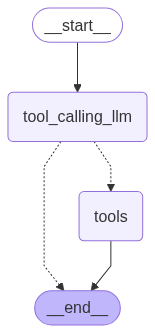

In [13]:
## Entire chatbot with Langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)

builder.add_edge('tools',END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:

messages=graph.invoke({"messages":"What is attention is all you need?"})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (mhn7a6chs)
 Call ID: mhn7a6chs
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


## React Agent Architecture in LangGraph

1. act = The model calls the specific tools
2. observe = Passes the output back to the model
3. reason = Based on the output response of the tool, the model will decide what to do in the next step --> smart agents

In [15]:
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']=os.getenv('LANGCHAIN_PROJECT')

In [16]:
## Custom functions --> tools

def multiply(a: int,b: int)->int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int,b: int)->int:
    """
    Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int,b: int)->int:
    """
    Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def divide(a: int,b: int)->int:
    """
    Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a // b

In [17]:
## Travily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/ly/spbnwbv12839h6wrzlnkytf00000gn/T/ipykernel_21297/2492452247.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [18]:
tavily.invoke("Provide me the latest news on Independence day today -  15'th Aug, 2025")

[{'title': 'Independence Day highlights: PM Modi pitches for GST reforms',
  'url': 'https://www.thehindu.com/news/national/india-indepdence-day-2025-live-updates-on-august-15-pm-modi-speech/article69935688.ece',
  'content': 'Prime Minister Narendra Modi on Friday (August 15, 2025) announced a project to develop an indigenous air-defence system to protect India’s vital military and civilian installations and deliver a decisive response to any enemy threat, a move that came amid concerns over security challenges emanating from Pakistan and China. [...] Prime Minister Narendra Modi on Friday (August 15, 2025) announced a National Deep Water Exploration Mission aimed at discovering oil and gas reserves beneath the seabed, as part of efforts to boost domestic production and reduce the country’s multi-billion-dollar import bill. [...] ## On the Indus Waters Treaty, the Prime Minister said it had caused enormous harm to agriculture in India. He said the attack in Pahalgam underscored the fu

In [19]:
tools=[tavily,arxiv,wiki,add,multiply,subtract,divide]


In [20]:
llm_with_tools=llm.bind_tools(tools)

In [21]:
from pprint import pprint

from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest news on Independence day 15 Aug 2025'},
  'id': 'rp9s6dajw',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'qvrd3qgac',
  'type': 'tool_call'}]

In [22]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [23]:
## chatbot node functionality

def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}



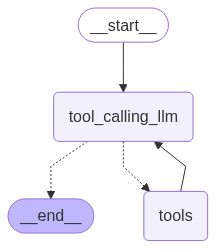

In [24]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')


graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages=graph.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")}) # type: ignore
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ydmvtg5wt)
 Call ID: ydmvtg5wt
  Args:
    query: latest news on Independence Day 15th August 2025
  add (4d652bskc)
 Call ID: 4d652bskc
  Args:
    a: 2
    b: 2
  multiply (bfwbztb0e)
 Call ID: bfwbztb0e
  Args:
    a: 4
    b: 6
  divide (dzm3ta6ts)
 Call ID: dzm3ta6ts
  Args:
    a: 24
    b: 3
  subtract (v6fprey59)
 Call ID: v6fprey59
  Args:
    a: 8
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What were the key announcements in PM Modi's Independence Day ...", "url": "https://www.thehindu.com/news/national/what-were-the-key

## Agent with memory in LangGraph

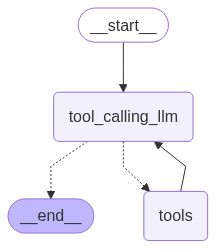

In [26]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_with_memory=builder.compile(checkpointer=memory) ## saved in memory

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
## specify the thread

config={
    "configurable":{"thread_id":"1"} ## specific to one user
}
messages=graph_with_memory.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")},config=config) # type: ignore
for message in messages['messages']:
    message.pretty_print()


================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (178npnbs9)
 Call ID: 178npnbs9
  Args:
    query: latest news on Independence Day 15th August 2025
  add (sejghgzgs)
 Call ID: sejghgzgs
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What were the key announcements in PM Modi's Independence Day ...", "url": "https://www.thehindu.com/news/national/what-were-the-key-announcements-in-pm-modis-independence-day-2025-speech/article69935897.ece", "content": "Published - August 15, 2025 11:18 am IST\n\nPrime Minister Narendra Modi being accorded a Guard of Honour during the

In [28]:
from typing import Annotated,List
from typing_extensions import Literal
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

planner=llm.with_structured_output(Sections)

In [29]:
### Creating Workers Dynamically in LangGraph

from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_sections: Annotated[list,operator.add]
    final_report:str

class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]

/var/folders/ly/spbnwbv12839h6wrzlnkytf00000gn/T/ipykernel_21297/339909892.py:3: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [30]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections=planner.invoke(
        [
            SystemMessage(content='Generate a plan for the report.'),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print('Report Sections:',report_sections)

    return {"sections":report_sections.sections} #type:ignore

In [31]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [32]:
urls = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/agents/agents/",
    "https://langchain-ai.github.io/langgraph/tutorials/langgraph-platform/local-server/"
]

docs=[WebBaseLoader(urls).load() for url in urls]

In [33]:
doc_list=[item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=100)
docs_splits=text_splitter.split_documents(doc_list)

In [34]:
vectorstore = FAISS.from_documents(
    documents=docs_splits,
    embedding=HuggingFaceEmbeddings()
)

retriever = vectorstore.as_retriever()

/Users/rishavchatterjee/Desktop/AgenticAi/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
retriever.invoke("What is backtracking?")

[Document(id='a1caf6f7-9240-4886-bba2-479aa90490fd', metadata={'source': 'https://langchain-ai.github.io/langgraph/', 'title': 'LangGraph', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='Durable execution: Build agents that persist through failures and can run for extended periods, automatically resuming from exactly where they left off.\nHuman-in-the-loop: Seamlessly incorporate human oversight by inspecting and modifying agent state at any point during execution.\nComprehensive memory: Create truly stateful agents with both short-term working memory for ongoing reasoning and long-term persistent memory across sessions.\nDebugging with LangSmith: Gain deep visibility into complex agent behavior with visualization tools that trace execution paths, capture state transitions, and provide detailed runtime metrics.\nProduction-ready deployment: Deploy sophisticated agent systems confidently with scalable infrastructure desi

In [36]:
## retriever --> Retriever tools

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_langgraph",
    "serch and run information about langgraph"
)

In [37]:
urls2 = [
    "https://namastedev.com/blog/network-security-fundamentals/",
    "https://namastedev.com/blog/organizing-tasks-with-trello-boards-2/",
    "https://namastedev.com/blog/introduction-to-backtracking/"
]

docs2=[WebBaseLoader(urls2).load() for url in urls2]

In [38]:
doc_list2=[item for sublist in docs2 for item in sublist]

text_splitter2 = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=100)
docs_splits2=text_splitter2.split_documents(doc_list2)

In [39]:
vectorstore2 = FAISS.from_documents(
    documents=docs_splits2,
    embedding=HuggingFaceEmbeddings()
)

retriever2 = vectorstore2.as_retriever()

In [40]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool_blogs = create_retriever_tool(
    retriever2,
    "retriever_vector_db_blog",
    "serch and run information about blogs on web dev"
)

In [41]:
tools = [retriever_tool,retriever_tool_blogs]

In [67]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

In [68]:
from langchain_groq import ChatGroq

llm = ChatGroq(model='qwen/qwen3-32b')
llm.invoke('hi')

AIMessage(content='<think>\nOkay, the user sent "hi". That\'s a greeting. I should respond in a friendly and welcoming way. Let me make sure to acknowledge their greeting and offer assistance. Maybe something like, "Hello! How can I assist you today?" That sounds good. I need to keep it open-ended so they feel comfortable asking for help with anything. No need for any markdown here since it\'s a simple response. Alright, that should do it.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 9, 'total_tokens': 115, 'completion_time': 0.201927666, 'prompt_time': 0.015486517, 'queue_time': 0.051454353, 'total_time': 0.217414183}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc206265-11cd-46b5-8d16-966f886fefd0-0', usage_metadata={'input_tokens': 9, 'output_tokens': 106, 'total_tokens'

In [75]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state.
    Given the question, It will decide to retrieve using the retriever tool or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response added to the messages
    """
    print('----CALL AGENT----')
    messages=state['messages']
    model = ChatGroq(model='qwen/qwen3-32b')
    model = model.bind_tools(tools)
    response=model.invoke(messages)
    return {'messages':[response]}

In [76]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict, Literal

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]: # type: ignore
  """
  Determines whether the retrieved documents are relevant to the question.

  Args:
    state (messages): The current state

  Returns:
    str: A decision for whether the documents are relevant or not
  """

  print("---CHECK RELEVANCE---")

  # Data model
  class grade(BaseModel):
      """Binary score for relevance check."""

      binary_score: str = Field(description="Relevance score 'yes' or 'no'")

  # LLM
  model = ChatGroq(model="qwen/qwen3-32b")

  # LLM with tool and validation
  llm_with_tool = model.with_structured_output(grade)

  # Prompt
  prompt = PromptTemplate(
      template="""You are a grader assessing relevance of a retrieved document to a user question. \n
      Here is the retrieved document: \n\n {context} \n\n
      Here is the user question: {question} \n
      If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
      Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
      input_variables=["context", "question"],
    )

  # Chain
  chain = prompt | llm_with_tool

  messages = state["messages"]
  last_message = messages[-1]

  question = messages[0].content
  docs = last_message.content

  scored_result = chain.invoke({"question": question, "context": docs})

  score = scored_result.binary_score # pyright: ignore[reportAttributeAccessIssue]

  if score == "yes":
      print("---DECISION: DOCS RELEVANT---")
      return "generate"
  else:
      print("---DECISION: DOCS NOT RELEVANT---")
      print(score)
      return "rewrite"

In [77]:
def generate(state):
    """
    Generate answer
 
    Args:
        state (messages): The current state
 
    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
 
    docs = last_message.content
 
    # Prompt
    prompt = hub.pull("rlm/rag-prompt")
 
    # LLM
    llm = ChatGroq(model="qwen/qwen3-32b")
 
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
 
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
 
    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [78]:
def rewrite(state):
    """
    Transform the query to produce a better question.
 
    Args:
        state (messages): The current state
 
    Returns:
        dict: The updated state with re-phrased question
    """
 
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
 
    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
 
    # Grader
    model = ChatGroq(model="qwen/qwen3-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

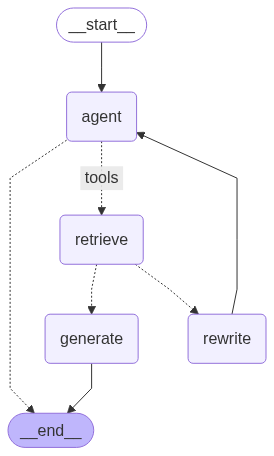

In [79]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
 
# Define a new graph
workflow = StateGraph(AgentState)
 
# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool,retriever_tool_blogs])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")
 
# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)
 
# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
 
# Compile
graphai = workflow.compile()
from IPython.display import Image, display
display(Image(graphai.get_graph(xray=True).draw_mermaid_png()))

In [80]:
graphai.invoke({'messages':'What is langgraph?'})

----CALL AGENT----
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is langgraph?', additional_kwargs={}, response_metadata={}, id='a2578716-ee71-4810-a557-aedd5ab3e11f'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is langgraph?" I need to figure out which tool to use here. Let me check the available functions. There\'s retriever_vector_db_langgraph which is for searching information about langgraph, and retriever_vector_db_blog for web dev blogs.\n\nSince the question is specifically about what langgraph is, the best bet is to use the langgraph retriever. The blog one might have some info, but the primary source would be the langgraph-specific function. So I\'ll go with retriever_vector_db_langgraph and input the query "What is langgraph?" to get the relevant information.\n', 'tool_calls': [{'id': '9tjdtx5gb', 'function': {'arguments': '{"query":"What is langgraph?"}', 'name': 'retriever_vector_db_langgraph'}, 'type': 'function'}]}, response_metadata={'token